In [2]:
import requests
from bs4 import BeautifulSoup

# Find a list of all links leading to each month's articles
def issue_link_finder():
    import re

    url = "https://dailytrojan.com/archives/#tab-id-5"

    # Make a request to the website
    response = requests.get(url)
    html_content = response.content

    # Parse the html content using BeautifulSoup
    soup = BeautifulSoup(html_content, "html.parser")

    # Initialize an empty list to store links of each possible subdirectory
    links = []  

    # Find all the links on the website
    li_tags = soup.find_all("li")
    for li in li_tags:
        a = li.find('a')
        link = a.get('href')
        if bool(re.match("^https://dailytrojan\.com/20\d{2}/\d{2}/$", link)):
            links.append(link)
    
    return links

# Find all possible dates (representing all issues) for a given
def get_subpages(url):
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")

    nav_tag = soup.find('nav', class_='pagination')
    if not nav_tag:
        return [url]
    
    max_page = int(nav_tag.find('span', class_='pagination-meta').text.split()[-1])
    subpages = [f"{url}page/{i}/" for i in range(2, max_page+1)]

    return [url] + subpages

def get_article_links_and_dates(url):
    # Fetch the HTML content for the page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the article links and dates within the page
    article_links = {}
    article_dates = set()
    for article in soup.find_all('article'):
        link = article.find('a')['href']
        date = link.split('/')[3:6]
        date = '_'.join(date)
        article_dates.add(date)
        if date in article_links:
            article_links[date].append(link)
        else:
            article_links[date] = [link]

    return article_links, article_dates

from helpers.txt_to_text import get_article_text

from helpers.make_txt_entry import make_txt_entry

In [3]:
issue_links = issue_link_finder()

In [4]:
sub_pages = []
for url in issue_links:
    sub_pages.append(get_subpages(url))

In [6]:
print(f"There are {len(issue_links)} months")
sub_page_count = sum([len(sub_page) for sub_page in sub_pages])
print(f"There are {sub_page_count} total sub-pages to traverse")

There are 167 months
There are 3246 total sub-pages to traverse


In [ ]:
import json

article_dates = set()
article_pages = {}

for month_sub_pages in sub_pages:
    for sub_page in month_sub_pages:
        try:
            article_links, dates = get_article_links_and_dates(sub_page)
            for date in dates:
                if date in article_pages:
                    article_pages[date].extend(article_links[date])
                else:
                    article_pages[date] = article_links.copy()[date]
                    print(f"Date {date} added.")
            article_dates.update(dates)
        except ConnectionError as ce:
            print(ce, month_sub_pages)

with open("usc_article_pages.json", "w") as outfile:
    json.dump(article_pages, outfile, indent=4)

In [10]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 3118 dates with articles
There are 31710 articles to iterate over


In [ ]:
import os

school_name = "USC"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = ""
        for article in articles:
            article_text += get_article_text(article) + "\n"
            
        make_txt_entry(school_name="USC", publication_date=date, text=article_text)
        print(f"Date {date} added.")

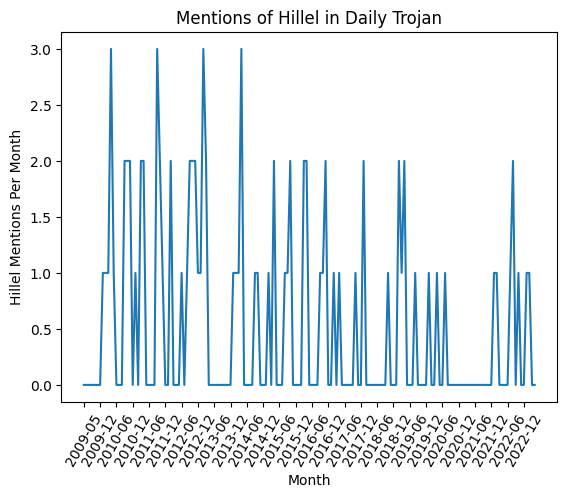

In [1]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter
from helpers.processors import text_removal_processing

with open("usc_text.txt", "r", encoding="utf8") as f:
    USC_TEXT = f.read()

USC_pipeline = [text_removal_processing(removable_string=USC_TEXT)]

directory = 'journal_data/txt/USC'

monthly_grapher(directory=directory,
                pipeline=USC_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in Daily Trojan",
                save_path='figures/USC_hillel_mentions.png')


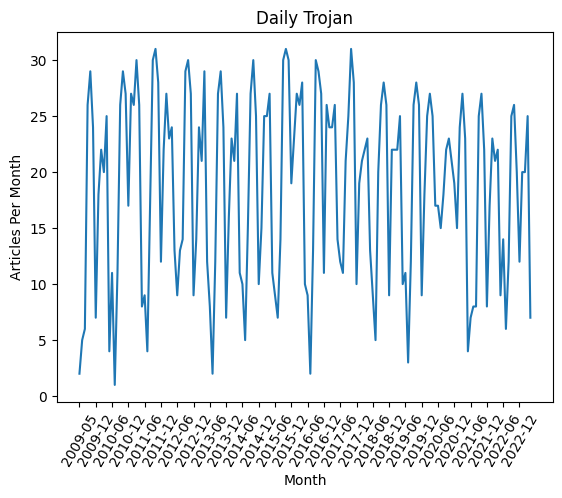

In [6]:
from helpers.queries import one_query
from helpers.graphers import monthly_grapher

directory = 'journal_data/txt/USC'

monthly_grapher(directory=directory,
                pipeline=[],
                query=one_query,
                y_label="Articles Per Month",
                title="Daily Trojan",
                save_path='figures/USC_monthly_articles.png')


grouped_data/csv/USC_Israel.csv created.
grouped_data/pkl/monthly/USC_Israel.pkl being created.


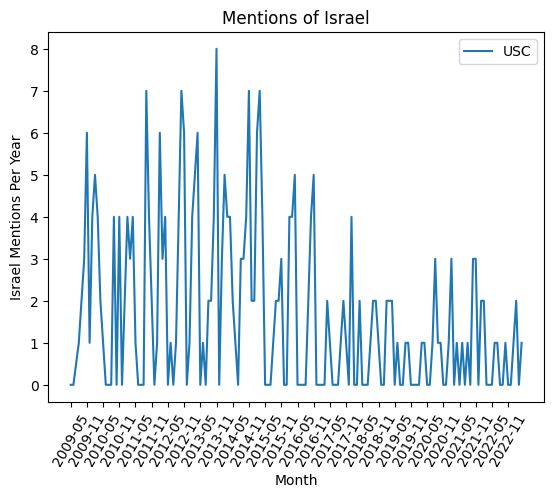

In [4]:
# Hyperparameters to Modify
school_name = 'USC'
string = "Israel"
time_slice = 'monthly'

from helpers.graphers import grapher
from helpers.queries import count_query

school_names = [school_name]
save_pattern = '_'.join(school_names)+'_'+string.replace(' ','_')
grapher(school_names=school_names,
        pipeline=[],
        query=count_query(string),
        y_label=f"{string} Mentions Per Year",
        data_path="grouped_data",
        data_name=save_pattern,
        time_slice=time_slice,
        title=f"Mentions of {string}",
        img_path=f"figures/{school_name}/{save_pattern}_{time_slice}.png")